In [1]:
#%% Imports
import os
import numpy as np
import spectral
import matplotlib.pyplot as plt
from skimage import exposure, io

from scipy import stats
from sklearn.linear_model import LinearRegression

# Import "local" packages
import hyspec_io, image_render, preprocess, misc 

In [2]:
import importlib
importlib.reload(preprocess)

<module 'preprocess' from '/home/mha114/Dropbox/Python/massimal/tools/preprocess.py'>

In [4]:
#%% Paths
train_file = '/media/mha114/Massimal/Larvik_Olberg/Hyperspectral/20210825/OlbergAreaS/Radiance/OlbergholmenS_Pika_L_21-Radiance From Raw Data.bip.hdr'
test_file = '/media/mha114/Massimal/Larvik_Olberg/Hyperspectral/20210825/OlbergAreaS/Radiance/OlbergholmenS_Pika_L_17-Radiance From Raw Data.bip.hdr'
output_dir = '/media/mha114/Massimal/Larvik_Olberg/Hyperspectral/Test_Deglint'

In [5]:
#%% Import data
(im_train,wl,rgb_ind,metadata) = hyspec_io.load_envi_image(train_file)
(im_test,wl,rgb_ind,metadata) = hyspec_io.load_envi_image(test_file)

In [25]:
class HedleySunGlint:
    """ Hedley sun glint removal regression model

    # Usage:
    GlintMod = HedleySunGlint()

    # Notes:
    This implementation is based on the following paper: Hedley, J. D.,
    Harborne, A. R., & Mumby, P. J. (2005). Technical note: Simple and robust
    removal of sun glint for mapping shallow‐water benthos. International
    Journal of Remote Sensing, 26(10), 2107–2112.
    https://doi.org/10.1080/01431160500034086

    """

    def __init__(self, vis_band = (350,750), nir_band = (780,840)):
        """ Hedley sun glint removal: Model instantiation

        # Optional arguments:
        vis_band:   2-element tuple with upper and lower wavelength of VIS band (nm).
        nir_band:   2-element tuple with upper and lower limit of NIR band.
                    The NIR band is used to estimate the amount of sun glint present
                    in the VIS band.
        """
        self.vis_band = vis_band
        self.nir_band = nir_band


    def fit(self,spec,wl):
        """ Fit a linear regression model connecting NIR and VIS data

        # Required arguments:
        spec:   2D numpy array with hyperspectral image, wavelengths along 2nd dim.
                The cube should contain data from a homogenous bottom (e.g. deep sea)
                and a representative variation of sun/sky glint.
        wl:     1D array of wavelenghs (numeric). Must match the size of the 2nd
                dimension of spec.
                
        # Notes:
        The function will ignore data that is equal to zero across all bands 
        (typically non-valid pixels that have been actively set to zero). 
                
        """

        # Calculate VIS and NIR indices
        self.wl = wl
        self.vis_ind = (wl >= self.vis_band[0]) & (wl <= self.vis_band[1])
        self.nir_ind = (wl >= self.nir_band[0]) & (wl <= self.nir_band[1])

        # Calculate data mask for valid (non-zero) data points
        nz_mask = ~np.all(spec==0,axis=1)
        
        # Calculate mean NIR value in band
        # NOTE: "Double indexing" needed for broadcasting to work
        nir = np.mean(spec[nz_mask][:,self.nir_ind], axis=1, keepdims=True)

        # Extract VIS data
        vis = spec[nz_mask][:,self.vis_ind]

        # Fit a linear regression model
        reg = LinearRegression().fit(nir, vis)
        self.b = np.reshape(reg.coef_,(1,-1))   # Row vector, for mat. mult.

        # Estimate minimum NIR value as 2nd percentile (more robust than strict minimum)
        self.min_nir = np.percentile(nir,2)


    def remove_glint(self,data,invalid_threshold=0.1):
        """ Remove sun glint by applying previously trained model

        # Required arguments:
        data:   2D or 3D spectral data, wavelengths along last dim.
                The wavelengths must match those of the training data unsed
                to fit the model.

        # Optional arguments
        invalid_threshold:  Number between 0 and 1, indicating the fraction of
                            invalid pixels that is tolerated. Glint correction
                            can cause pixels to have negative values, and these
                            are considerend invalid and set to zero. If the
                            threshold is exceeded, the whole spectrum for the
                            pixel is set to zero.

        # Returns:
        vis:    2D or 3D spectral data, limited to visible range, with sun
                glint removed.
        """

        # Shape into 2D array, save original shape for later
        input_shape = data.shape
        data = np.reshape(data,(-1,data.shape[-1]))

        # Extract VIS and NIR bands
        vis = data[:,self.vis_ind]
        nir = np.mean(data[:,self.nir_ind], axis=1, keepdims=True)

        # Offset NIR, taking into account "ambient" (minimum) NIR
        # NOTE: This may be unnecessary for UAV data (minimal atmosphere effects)?
        nir = nir - self.min_nir
        nir[nir < 0] = 0

        # Estimate sun glint in VIS range and subtract it
        vis = vis - nir @ self.b    # Matrix mult. with slope b for each VIS band

        # Set negative values to zero (negative values are non-physical)
        vis[vis < 0] = 0

        # Reshape data to fit original dimensions
        output_shape = input_shape[:-1] + (vis.shape[-1],)
        vis = np.reshape(vis,output_shape)

        # Set invalid pixels (too many zeros) to all-zeros
        zeros_fraction = np.count_nonzero(vis == 0, axis=2) / vis.shape[2]
        invalid_mask = zeros_fraction > invalid_threshold
        vis[invalid_mask] = 0

        # Set negative VIS values to zero
        # Currently not included because it discards too much data
        # neg_pix = np.any( vis < 0, axis = 2)
        # vis[neg_pix] = 0

        # Return
        return vis

In [11]:
#%% Detect saturated pixels in training data
#sat_pix_mask = preprocess.detect_saturated(im_train_raw)
#print('Number of saturated pixels: ' + str(np.count_nonzero(sat_pix_mask)))

In [8]:
#spec_train = im_train[~sat_pix_mask]
spec_train = np.reshape(im_train,(-1,im_train.shape[2]))
spec_train.shape

(959400, 300)

In [26]:
#%% Create Hedley sun glint correction object
# sgc = preprocess.HedleySunGlint()
sgc = HedleySunGlint()
sgc.fit(spec_train,wl)

(959400,)


In [27]:
im_test_sgc = sgc.remove_glint(im_test)

In [28]:
im_test_sgc.shape

(2000, 900, 173)

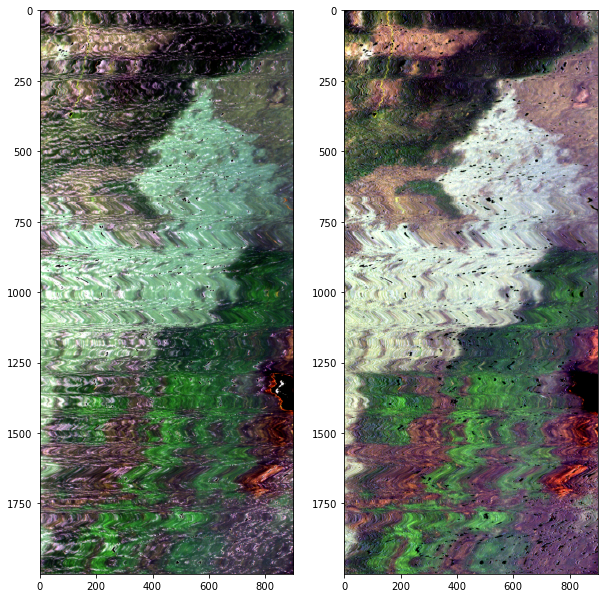

In [35]:
#%% Show original and glint corrected image
fig,ax = plt.subplots(ncols=2,figsize=(10,12))
ax[0].imshow(image_render.percentile_stretch(im_test[:,:,rgb_ind]))
ax[1].imshow(image_render.percentile_stretch(im_test_sgc[:,:,rgb_ind]))

In [31]:
save_file_path = misc.build_newdir_filepath([test_file],output_dir)
print(save_file_path)

['/media/mha114/Massimal/Larvik_Olberg/Hyperspectral/Test_Deglint/OlbergholmenS_Pika_L_17-Radiance From Raw Data.bip.hdr']


In [32]:
metadata['wavelength'] = [metadata['wavelength'][ii] for ii in range(len(wl)) if sgc.vis_ind[ii]]

In [33]:
metadata['wavelength']

['390.86',
 '392.87',
 '394.88',
 '396.89',
 '398.9',
 '400.91',
 '402.92',
 '404.93',
 '406.94',
 '408.96',
 '410.97',
 '412.99',
 '415.0',
 '417.02',
 '419.04',
 '421.06',
 '423.08',
 '425.1',
 '427.12',
 '429.14',
 '431.17',
 '433.19',
 '435.22',
 '437.24',
 '439.27',
 '441.3',
 '443.33',
 '445.36',
 '447.39',
 '449.42',
 '451.45',
 '453.49',
 '455.52',
 '457.56',
 '459.59',
 '461.63',
 '463.67',
 '465.71',
 '467.75',
 '469.79',
 '471.83',
 '473.87',
 '475.91',
 '477.96',
 '480.0',
 '482.05',
 '484.1',
 '486.14',
 '488.19',
 '490.24',
 '492.29',
 '494.34',
 '496.39',
 '498.45',
 '500.5',
 '502.56',
 '504.61',
 '506.67',
 '508.73',
 '510.79',
 '512.84',
 '514.9',
 '516.97',
 '519.03',
 '521.09',
 '523.15',
 '525.22',
 '527.29',
 '529.35',
 '531.42',
 '533.49',
 '535.56',
 '537.63',
 '539.7',
 '541.77',
 '543.84',
 '545.92',
 '547.99',
 '550.07',
 '552.14',
 '554.22',
 '556.3',
 '558.38',
 '560.46',
 '562.54',
 '564.62',
 '566.7',
 '568.78',
 '570.87',
 '572.95',
 '575.04',
 '577.13',

In [34]:
spectral.envi.save_image(save_file_path[0],im_test_sgc,dtype='uint16',metadata=metadata,force=True,ext=None)

In [36]:
im_copy = np.copy(im_train)

In [37]:
im_copy.shape

(1066, 900, 300)

In [41]:
im_copy = im_copy.reshape((-1,im_copy.shape[2]))

In [42]:
im_copy.shape

(959400, 300)